In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# veri yolu
base_dir = '/drive/MyDrive/dataset/BreaKHis 400X'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

# Veri arttırma
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

Found 1148 images belonging to 2 classes.
Found 545 images belonging to 2 classes.


In [ ]:
# Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
model.summary()

In [ ]:
plot_model(model, to_file='ResNet50_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Model eğitimi
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

Epoch 1/20
36/36 [==============================] - 481s 13s/step - loss: 0.6425 - accuracy: 0.6594 - val_loss: 0.6208 - val_accuracy: 0.6771
Epoch 2/20
36/36 [==============================] - 356s 10s/step - loss: 0.6634 - accuracy: 0.6611 - val_loss: 0.6226 - val_accuracy: 0.6771
Epoch 3/20
36/36 [==============================] - 351s 10s/step - loss: 0.6390 - accuracy: 0.6655 - val_loss: 0.6561 - val_accuracy: 0.6477
Epoch 4/20
36/36 [==============================] - 340s 10s/step - loss: 0.6655 - accuracy: 0.6307 - val_loss: 0.6271 - val_accuracy: 0.6789
Epoch 5/20
36/36 [==============================] - 379s 11s/step - loss: 0.6323 - accuracy: 0.6742 - val_loss: 0.6393 - val_accuracy: 0.6844
Epoch 6/20
36/36 [==============================] - 337s 9s/step - loss: 0.6540 - accuracy: 0.6446 - val_loss: 0.6365 - val_accuracy: 0.6771
Epoch 7/20
36/36 [==============================] - 344s 10s/step - loss: 0.6425 - accuracy: 0.6498 - val_loss: 0.6190 - val_accuracy: 0.6771
Epoch 8

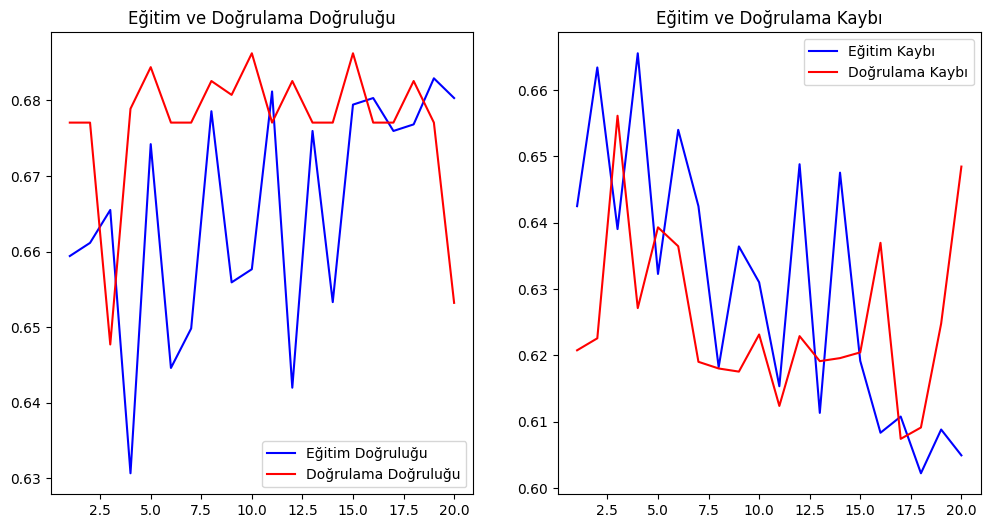

En Yüksek Eğitim Doğruluğu: 0.6829268336296082
En Yüksek Doğrulama Doğruluğu: 0.6862385272979736
En Düşük Eğitim Kaybı: 0.6022447943687439
En Düşük Doğrulama Kaybı: 0.6074294447898865


In [ ]:
# Görselleştirme
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b-', label='Eğitim Doğruluğu')
plt.plot(epochs, val_acc, 'r-', label='Doğrulama Doğruluğu')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Eğitim Kaybı')
plt.plot(epochs, val_loss, 'r-', label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.legend()

plt.show()

highest_training_accuracy = max(acc)
highest_validation_accuracy = max(val_acc)
lowest_training_loss = min(loss)
lowest_validation_loss = min(val_loss)

print("En Yüksek Eğitim Doğruluğu:", highest_training_accuracy)
print("En Yüksek Doğrulama Doğruluğu:", highest_validation_accuracy)
print("En Düşük Eğitim Kaybı:", lowest_training_loss)
print("En Düşük Doğrulama Kaybı:", lowest_validation_loss)

18/18 [==============================] - 106s 6s/step
Accuracy (Doğruluk): 0.5321100917431193
Precision (Kesinlik): 0.6637931034482759
Recall (Geri Çağırma): 0.6260162601626016
F1 Score: 0.6443514644351465

Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.30      0.34      0.32       176
           1       0.66      0.63      0.64       369

    accuracy                           0.53       545
   macro avg       0.48      0.48      0.48       545
weighted avg       0.55      0.53      0.54       545


Karışıklık Matrisi:
 [[ 59 117]
 [138 231]]


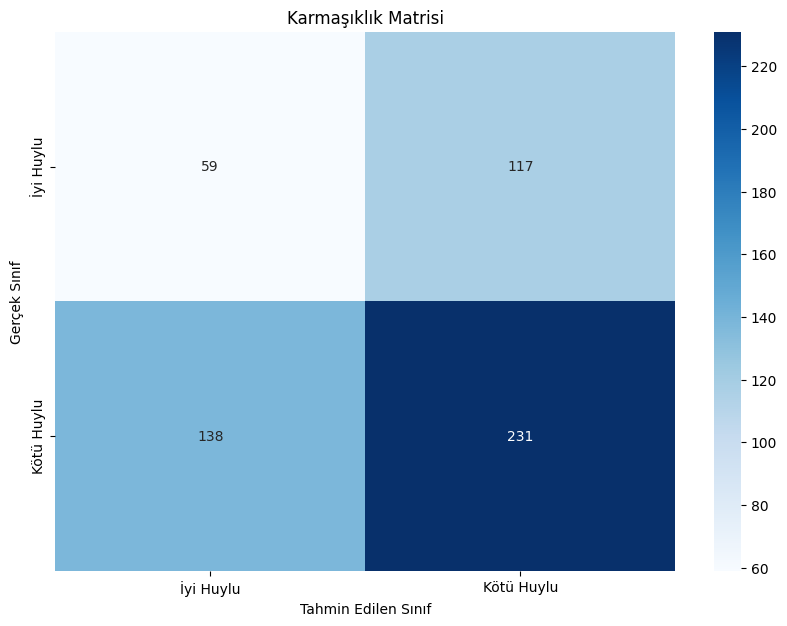

In [ ]:
# Tahminlerin yapılması
validation_generator.reset()
preds = model.predict(validation_generator, steps=len(validation_generator), verbose=1)
preds = np.round(preds).astype(int).reshape(-1)

# Gerçek etiketlerin alınması
true_labels = validation_generator.classes

# Metriklerin hesaplanması
accuracy = accuracy_score(true_labels, preds)
precision = precision_score(true_labels, preds)
recall = recall_score(true_labels, preds)
f1 = f1_score(true_labels, preds)

print("Accuracy (Doğruluk):", accuracy)
print("Precision (Kesinlik):", precision)
print("Recall (Geri Çağırma):", recall)
print("F1 Score:", f1)

# Ayrıntılı sınıflandırma raporu
print("\nSınıflandırma Raporu:\n", classification_report(true_labels, preds))

# Confusion Matrix (Karmaşıklık Matrisi)
conf_matrix = confusion_matrix(true_labels, preds)
print("\nKarışıklık Matrisi:\n", conf_matrix)

# Confusion Matrix'i görselleştirme
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['İyi Huylu', 'Kötü Huylu'], yticklabels=['İyi Huylu', 'Kötü Huylu'])
plt.title('Karmaşıklık Matrisi')
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.show()